In [23]:
import cv2
import os
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

CELLS_DIR = "data/cells"
BACKGROUND_DIR = "data/background"
TARGET_SIZE = (64, 64)

def load_and_resize_patches(dir_path, target_size=TARGET_SIZE):
    patches = []
    for path in glob(os.path.join(dir_path, "*.png")):
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, target_size)
            patches.append(img)
    return patches


cell_patches = load_and_resize_patches(CELLS_DIR)
bg_patches = load_and_resize_patches(BACKGROUND_DIR)

print(f"Загружено клеток: {len(cell_patches)}, фоновых патчей: {len(bg_patches)}")

Загружено клеток: 0, фоновых патчей: 0


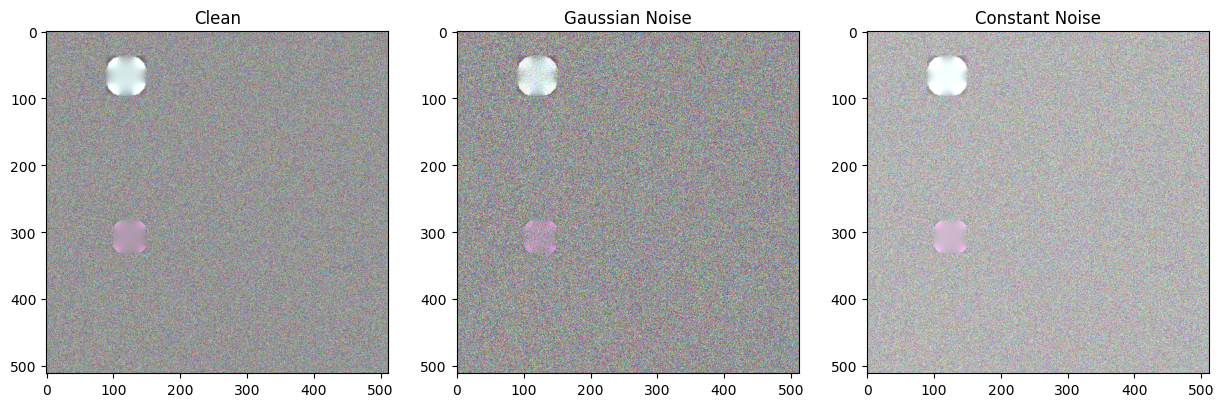

In [24]:
import cv2
import numpy as np
import random
import os
from glob import glob


def create_background_from_patches(image_size=(512, 512), patch_dir="data/background"):
    """Создает фон из предварительно сохраненных патчей"""
    background = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)
    patch_files = glob(os.path.join(patch_dir, "*.png"))

    patch_size = (64, 64)
    num_x = image_size[0] // patch_size[0]
    num_y = image_size[1] // patch_size[1]
    
    for i in range(num_y):
        for j in range(num_x):
            if patch_files:
                patch = cv2.imread(random.choice(patch_files))
                if patch is not None:
                    patch = cv2.resize(patch, patch_size)
                    y_start = i * patch_size[1]
                    x_start = j * patch_size[0]
                    background[y_start:y_start+patch_size[1], x_start:x_start+patch_size[0]] = patch
    return background


def add_gaussian_noise(image, mean=0, sigma=25):
    """Добавляет гауссовский шум"""
    row, col, ch = image.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = np.clip(image.astype(np.float32) + gauss, 0, 255).astype(np.uint8)
    return noisy


def add_constant_noise(image, noise_value=30):
    """Добавляет постоянный шум (равномерное смещение)"""
    image = image.astype(np.int16)
    noisy = image + noise_value
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy


def create_synthetic_background(image_size=(512, 512)):
    """Создает искусственный фон (равномерная заливка)"""
    bg_color = np.random.randint(100, 200, size=3)
    return np.full((image_size[1], image_size[0], 3), bg_color, dtype=np.uint8)

def generate_synthetic_cell():
    """Генерирует искусственную клетку (окружность)"""
    size = np.random.randint(30, 100)
    cell = np.zeros((size, size, 3), dtype=np.uint8)
    color = np.random.randint(0, 255, 3)
    cv2.circle(cell, (size//2, size//2), size//2, color.tolist(), -1)
    return cell

def data_generator(
    image_size=(512, 512), 
    max_cells=5,
    use_real_cells=True, 
    use_real_bg=True
):
    while True:
        if use_real_bg and bg_patches:
            bg = cv2.resize(random.choice(bg_patches), image_size)
        else:
            bg = np.random.randint(100, 200, (image_size[1], image_size[0], 3), dtype=np.uint8)
        
        clean_image = bg.copy()
        
        num_cells = random.randint(1, max_cells)
        
        for _ in range(num_cells):
            if use_real_cells and cell_patches:
                cell = random.choice(cell_patches)
            else:
                cell = generate_synthetic_cell()
                cell = cv2.resize(cell, TARGET_SIZE)
            
            scale = random.uniform(0.5, 1.5)
            cell = cv2.resize(cell, None, fx=scale, fy=scale)
            
            x = random.randint(0, clean_image.shape[1] - cell.shape[1])
            y = random.randint(0, clean_image.shape[0] - cell.shape[0])
            
            mask = 255 * np.ones(cell.shape[:2], dtype=np.uint8)
            center = (x + cell.shape[1]//2, y + cell.shape[0]//2)
            clean_image = cv2.seamlessClone(cell, clean_image, mask, center, cv2.NORMAL_CLONE)
        
        noisy_gaussian = add_gaussian_noise(clean_image)
        noisy_constant = add_constant_noise(clean_image)
        
        yield noisy_gaussian, noisy_constant, clean_image


gen = data_generator()
noisy_gaus, noisy_const, clean = next(gen)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(clean, cv2.COLOR_BGR2RGB)), plt.title("Clean")
plt.subplot(1, 3, 2), plt.imshow(cv2.cvtColor(noisy_gaus, cv2.COLOR_BGR2RGB)), plt.title("Gaussian Noise")
plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(noisy_const, cv2.COLOR_BGR2RGB)), plt.title("Constant Noise")
plt.show()

In [20]:
from skimage.metrics import mean_squared_error as mse, structural_similarity as ssim
import time

def evaluate_denoisers(clean, noisy):
    results = {}
    
    # Проверка размера изображения
    min_dim = min(clean.shape[:2])
    win_size = min(7, min_dim if min_dim % 2 == 1 else min_dim - 1)  # Гарантируем нечетность
    
    # Медианный фильтр
    start = time.time()
    denoised = cv2.medianBlur(noisy, 3)
    results['median'] = {
        'mse': mse(clean, denoised),
        'ssim': ssim(clean, denoised, win_size=win_size, channel_axis=-1),
        'time': time.time() - start
    }
    
    # Гауссов фильтр
    start = time.time()
    denoised = cv2.GaussianBlur(noisy, (5,5), 0)
    results['gaussian'] = {
        'mse': mse(clean, denoised),
        'ssim': ssim(clean, denoised, win_size=win_size, channel_axis=-1),
        'time': time.time() - start
    }
    
    # Билатеральный фильтр
    start = time.time()
    denoised = cv2.bilateralFilter(noisy, 9, 75, 75)
    results['bilateral'] = {
        'mse': mse(clean, denoised),
        'ssim': ssim(clean, denoised, win_size=win_size, channel_axis=-1),
        'time': time.time() - start
    }
    
    # NL-means
    start = time.time()
    denoised = cv2.fastNlMeansDenoisingColored(noisy, None, 10, 10, 7, 21)
    results['nlmeans'] = {
        'mse': mse(clean, denoised),
        'ssim': ssim(clean, denoised, win_size=win_size, channel_axis=-1),
        'time': time.time() - start
    }
    
    return results

# Сбор статистики
noise_types = ['gaussian', 'constant']
stats = {nt: {f: {'mse': [], 'ssim': [], 'time': []} for f in ['median', 'gaussian', 'bilateral', 'nlmeans']} for nt in noise_types}

for _ in range(10):  # На 10 изображениях
    ng, nc, cl = next(gen)
    res_g = evaluate_denoisers(cl, ng)
    res_c = evaluate_denoisers(cl, nc)
    for f in res_g:
        stats['gaussian'][f]['mse'].append(res_g[f]['mse'])
        stats['gaussian'][f]['ssim'].append(res_g[f]['ssim'])
        stats['gaussian'][f]['time'].append(res_g[f]['time'])
    for f in res_c:
        stats['constant'][f]['mse'].append(res_c[f]['mse'])
        stats['constant'][f]['ssim'].append(res_c[f]['ssim'])
        stats['constant'][f]['time'].append(res_c[f]['time'])

# Вывод результатов
def print_stats(stats_dict, noise_type):
    print(f"Результаты для {noise_type} шума:")
    for filt in stats_dict[noise_type]:
        avg_mse = np.mean(stats_dict[noise_type][filt]['mse'])
        avg_ssim = np.mean(stats_dict[noise_type][filt]['ssim'])
        avg_time = np.mean(stats_dict[noise_type][filt]['time'])
        print(f"{filt}: MSE={avg_mse:.2f}, SSIM={avg_ssim:.3f}, Время={avg_time:.3f} сек")

print_stats(stats, 'gaussian')
print_stats(stats, 'constant')

Результаты для gaussian шума:
median: MSE=873.86, SSIM=0.220, Время=0.078 сек
gaussian: MSE=690.25, SSIM=0.286, Время=0.071 сек
bilateral: MSE=400.70, SSIM=0.648, Время=0.103 сек
nlmeans: MSE=524.61, SSIM=0.479, Время=0.669 сек
Результаты для constant шума:
median: MSE=1682.02, SSIM=0.265, Время=0.079 сек
gaussian: MSE=1540.97, SSIM=0.299, Время=0.071 сек
bilateral: MSE=1282.88, SSIM=0.589, Время=0.103 сек
nlmeans: MSE=1585.86, SSIM=0.164, Время=0.665 сек
